In [10]:
import shap
import xgboost
import pandas as pd
import pickle
from cv_result_analyzer import CVResultAnalyzer
from sklearn.model_selection import StratifiedKFold

In [5]:
df = pd.read_csv('data/df_feats_assembled.csv')

# make dummies for agent, gender, first level, last_level
df_model = pd.get_dummies(df, columns=['agent', 'gender','first_level','last_level'], drop_first=True, dtype=int)

# rescale the timestamp so easier to work with
ref_ts = df_model.registration.min()
for col in ['registration','max_ts','min_ts']:
    df_model[col] = (df_model[col] - ref_ts)/3600/1000

# get the diff column
cols = [x for x in df_model.columns if f"{x}_recent" in df_model.columns]
df_model_change = df_model.copy()
for col in cols:
    df_model_change[f"{col}_recent_diff"] = df_model_change[f"{col}_recent"] - df_model_change[col]

# assemble the X, y
X, y = df_model_change.drop(columns=['churn', 'location']).values, df_model_change.churn.values
feats = df_model_change.drop(columns=['churn', 'location']).columns

In [13]:
def f1_eval_error(y_true, dtrain):
    y_pred = np.where(dtrain>0.5, 1.0, 0.0)
#     return 'f1_eval', f1_score(y_pred, y_true)
    return 1-f1_score(y_pred, y_true)

In [14]:
class CV_xgboost(CVResultAnalyzer):
    '''
       helper class to run grid search on xgboost
    '''
    def __init__(self, obj="binary:logistic"):
        self.objective = obj
    
    def fit(self, X, y, param_grid, kf=StratifiedKFold(n_splits=4), verbose=True, target='1'):
        ''' do some cv on param_grid '''
        cols = defaultdict(list)
        
        # loop over each param combination
        param_names, param_vals = list(zip(*param_grid.items()))
        for param_val in product(*param_vals):
            param = dict(zip(param_names, param_val))
            print(f"doing {param}")
            for k, v in param.items():
                cols[k].append(v)
            
            # loop over the splits
            scores = []
            for train_idx, test_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                X_test, y_test = X[test_idx], y[test_idx]
                clf = XGBClassifier(**param, objective=self.objective)
                clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
                scores.append(clf.best_score)
            print(scores)
            
            # store the result for this test
            for isplit, score in enumerate(scores):
                cols[f'split_{isplit}'].append(score)
            cols['mean_test'].append(np.mean(scores))
            cols['std_test'].append(np.std(scores))
        
        # turn it into pd
        self.result_df = pd.DataFrame.from_dict(cols)
        self.result_df['target'] = target        
        self.result_df.reset_index(names=['id'], inplace=True) # this is useful in scatterplot
    
    def refit(self, X, y, best_param, kf=StratifiedKFold(n_splits=4), verbose=True):
        ''' 
          keep the clf for each split and when predict, give the average
          useful to fit at a lower learning rate
        '''
        self.clfs = []
        for train_idx, test_idx in kf.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            best_param['n_estimators'] = 10000 # first do an early stop
            clf = XGBClassifier(**best_param, objective=self.objective)
            clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
            # refit at the best point
            best_param['n_estimators'] = clf.best_ntree_limit # then do a refit at the best iter
            clf = XGBClassifier(**best_param, objective=self.objective)
            clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
            self.clfs.append(deepcopy(clf))
    
    def predict(self, X):
        p = self.predict_proba(X)[:,1]
        y_pred = np.where(p>0.5, 1, 0)
        return y_pred
    
    def predict_proba(self, X):
        for i, clf in enumerate(self.clfs):
            if i == 0:
                p = clf.predict_proba(X)
            else:
                p = p + clf.predict_proba(X)
        p = p / len(self.clfs)
        return p

In [15]:
with open('xgboost_no_state.pickle', 'rb') as fid:
    model = pickle.load(fid)

In [17]:
explainer = shap.Explainer(model.clfs[0], X)
shap_values = explainer(X)

100%|===================| 22233/22261 [03:19<00:00]        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


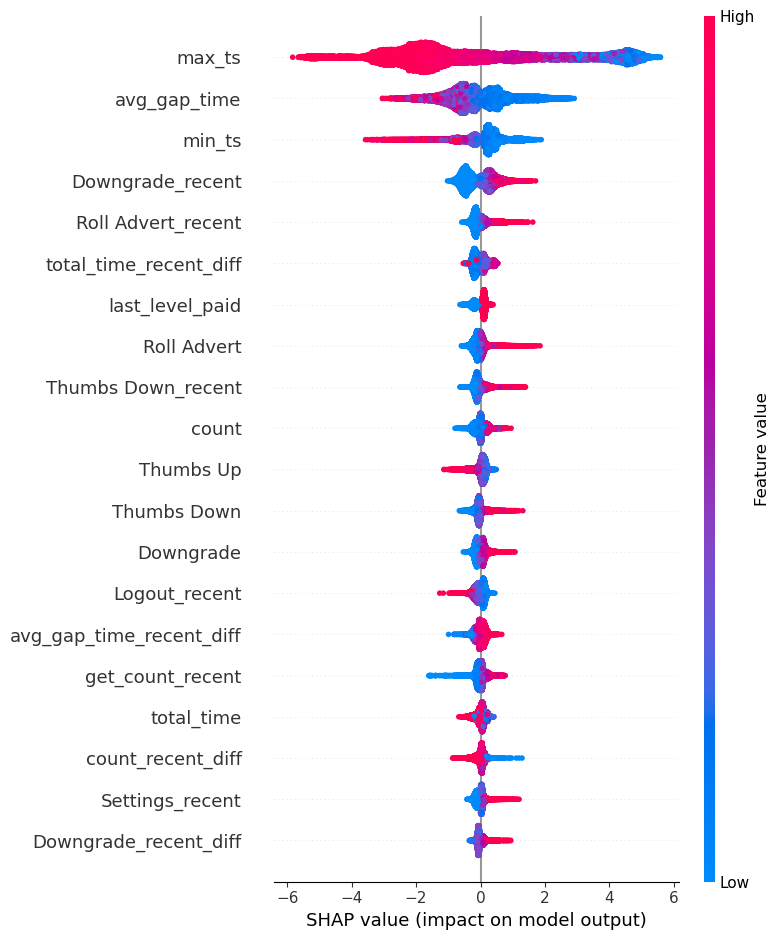

In [23]:
shap.summary_plot(shap_values, feature_names=feats, plot_type='dot')

So these are the ones more likely to churn:  
1. max_ts, min_ts: low, which means new to the system. 
2. avg_gap_time: this is somewhat counterintutive, customers with shorter gap time is more likely to churn
3. downgrade_recent: one a customer downgrades, it's more likely to finally cancle
4. roll_avert: when this happens often, it signals the churn
5. last_level_paid: well, this just means free service is preferred
6. thumbs_down: maybe give a discount when thumbs_down?